# Tutorial 1 - Getting Started
Download notebook: [ccsne_tutorial1.ipynb](https://github.com/mattias-ek/SIMPLE/blob/master/notebooks/ccsne_tutorial1.ipynb)

This is the first of several tutorials aimed at introducing the basic features of the SIMPLE package.

This tutorial will feature examples using isotope yields from core collapse supernovae (CCSNe) models although the basics will be the same for other types of models as well.

First lets import the ``simple`` package and and change the logging level will provide more detailed output from the simple package on what is happening behind the scenes. This is optional but can be useful at it provides more context in the event of errors or warnings raised by the code.

In [1]:
import simple
simple.set_logging_level('INFO')

## Loading the database
The database file consists of a collection of ``Model`` objects, each containing the isotope yields, and other relevant information, from a specific nucleosynthetic model. The CCSNe database contains data from 6 different CCSNe models sets, with each set consisting of 3 models for a total of 18 models. In addition, the database also contains relevant reference values, such as initial abundances used by the models and more accurate isotope masses.

The CCSNe database, or any other database, file is not included with the simple package. See [this page](https://mattias-ek.github.io/SIMPLE/user-guide/) for details on the database files and where to download them. The complete database file can be quite large, for example the CCSNe database file is ~120 MB compressed and several GB uncompressed, therefore it is recommended you only load the isotope yields and/or models you are interested in working with.

To specify which isotope yields to load we need to create an ``isolist``. The isolist can be a simple list, or a ``,`` seperated string, containing the isotopes of interest. In this case only the isotopes specified in this list will be loaded. However, for CCSNe models where the isotope yields represent the abundances shortly after the explosion, before many of the unstable isotopes have had time to decay, we can also create the isolist as a dictionary mapping the *final* isotope to a list of isotopes whose abundances will be added together to create the abundance of the *final* isotope. **Note** that this is only suitable for isotopes which would have completely decayed before the formation of the solar system. 

The formatting of isotope string must consist of the element symbol and the mass number, optionally seperated by a ``-``, however the order and capitalization is not important. For example ``105-Pd`` and ``pd105`` are both acceptable and will be parsed into ``Pd-105``, which is the working format of simple. You can also include a suffix in the isotope string, for example in these tutorials the ``*`` suffix denotes that the isotope abundance included all short-lived unstable progenitors.  The suffix must come at the end of the isotope string and must start with one of the following symbols ``*:_``. The suffix cannot contain the ``/`` character or any white space characters.

The [``asisotope``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.asisotope) function will parse an isotope string into the simple isotope format. This will return an [``Isotope``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.Isotope) object which is a subclass of ``str`` containing a few additional attributes and methods. For example, the ``.mass``, ``.symbol`` and ``.suffix`` attributes are strings representing the mass number, element symbol and suffix respectively. A ratio between two isotopes can be created with the [``asratio``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.asratio) function and the [``aselement``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.aselement) function creates just the element symbol. Finally, the [``asisotopes``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.asisotopes), [``asratios``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.asratios)and [``aselements``](https://mattias-ek.github.io/SIMPLE/api/utils/#simple.utils.aselements) functions return a tuple of the relevant strings.

In [2]:
db_path = "data/SIMPLE_CCSNe_v3.hdf5"
isolist = {
        'H-1': 'H-1',
        'He-4': 'He-4',
        'C-12': 'C-12',
        'O-16': 'O-16',
        'Ne-20': 'Ne-20',
        'Si-28': 'Si-28',
        'Al-26': 'Al-26',
        'S-32': 'S-32',
        'Mg-24': 'Mg-24',
        'N-14': 'N-14',
        'K-40': 'K-40',
        'Fe-54':  'Fe-54',
        'Fe-54*': 'Fe-54,Co-54',
        'Fe-56': 'Fe-56',
        'Fe-56*': 'Fe-56,Ni-56,Co-56,Mn-56,Cr-56',
        'Fe-57': 'Fe-57',
        'Fe-57*': 'Fe-57,Ni-57,Co-57,Mn-57,Cr-57',
        'Fe-58': 'Fe-58',
        'Fe-58*': 'Fe-58,Co-58,Mn-58,Cr-58',
        'Ni-58':  'Ni-58',
        'Ni-58*': 'Ni-58,Cu-58',
        'Ni-60':  'Ni-60',
        'Ni-60*': 'Ni-60,Cu-60,Zn-60,Co-60,Fe-60',
        'Ni-61':  'Ni-61',
        'Ni-61*': 'Ni-61,Cu-61,Zn-61,Co-61,Fe-61',
        'Ni-62': 'Ni-62',
        'Ni-62*': 'Ni-62,Cu-62,Zn-62,Co-62,Fe-62',
        'Ni-64': 'Ni-64',
        'Ni-64*': 'Ni-64,Cu-64',
}

---
The [``load_collection``](https://mattias-ek.github.io/SIMPLE/api/models/#simple.models.load_collection) function will attempt to load the specified file, if it does not exist it will create the file from the database file using the *default_isolist*. The ``where`` arguments can be used to select only a specific set of models. Here we wish to load all the models so we do not use this argument but you can see examples of how it is used a little further down in this tutorial. The function returns a [model collection object](https://mattias-ek.github.io/SIMPLE/api/models/#simple.models.ModelCollection) that contains all the loaded models together with some commonly used methods.

This function call, if it's not loading a pre-existing file, may result in multiple warnings about missing isotope abundances. The value of any missing isotope abundance set to ``0`` based on the assumption that either this isotope was not produced or that it has already decayed within the timeframe of the model.

With the ``Info`` logging level we will also see messages about converting arrays between ``mole`` and ``mass`` units. This is because the original data is stored as mass fractions but to properly account for radioactive decay the abundances need to be added together as moles. The default conversion method, used by the CCSNe models, is to divide or multiply the data by the mass number of the isotope.

**Note** When loading an existing file the *default_isolist* and *where* arguments are ignored, and thus it is not guaranteed the loaded file was created using the same arguments. To force the creation of a new file even is one already exists use the argument ``overwrite=True``.

In [3]:
models = simple.load_collection('data/CCSNe_FeNi.hdf5', db_path, default_isolist=isolist, overwrite=False)

Loading existing file: data/CCSNe_FeNi.hdf5
Loading file: data/CCSNe_FeNi.hdf5
Loading ref: W17 (IsoRef)
Loading ref: iniab2.0E-02GN93 (IsoRef)
Loading ref: iniab2.0E-02GN93_Lo03 (IsoRef)
Loading ref: iniab1.3E-02Lo03_Lo03_merged (IsoRef)
Loading ref: rau_solar_ref (IsoRef)
Loading ref: iniab1.3E-02As09_As09_merged (IsoRef)
Loading model: Ri18_m15 (CCSNe)
Loading model: Ri18_m20 (CCSNe)
Loading model: Ri18_m25 (CCSNe)
Loading model: Pi16_m15 (CCSNe)
Loading model: Pi16_m20 (CCSNe)
Loading model: Pi16_m25 (CCSNe)
Loading model: La22_m15 (CCSNe)
Loading model: La22_m20 (CCSNe)
Loading model: La22_m25 (CCSNe)
Loading model: Si18_m15 (CCSNe)
Loading model: Si18_m20 (CCSNe)
Loading model: Si18_m25 (CCSNe)
Loading model: Ra02_m15 (CCSNe)
Loading model: Ra02_m20 (CCSNe)
Loading model: Ra02_m25 (CCSNe)
Loading model: LC18_m15 (CCSNe)
Loading model: LC18_m20 (CCSNe)
Loading model: LC18_m25 (CCSNe)
Time to load file: 0:00:00.231281


---
The ``repr`` of the model collection object lists the different model and reference objects in the collection. 

In [4]:
models

Models in collection:

- **[0]** ``Ri18_m15`` (CCSNe)
- **[1]** ``Ri18_m20`` (CCSNe)
- **[2]** ``Ri18_m25`` (CCSNe)
- **[3]** ``Pi16_m15`` (CCSNe)
- **[4]** ``Pi16_m20`` (CCSNe)
- **[5]** ``Pi16_m25`` (CCSNe)
- **[6]** ``La22_m15`` (CCSNe)
- **[7]** ``La22_m20`` (CCSNe)
- **[8]** ``La22_m25`` (CCSNe)
- **[9]** ``Si18_m15`` (CCSNe)
- **[10]** ``Si18_m20`` (CCSNe)
- **[11]** ``Si18_m25`` (CCSNe)
- **[12]** ``Ra02_m15`` (CCSNe)
- **[13]** ``Ra02_m20`` (CCSNe)
- **[14]** ``Ra02_m25`` (CCSNe)
- **[15]** ``LC18_m15`` (CCSNe)
- **[16]** ``LC18_m20`` (CCSNe)
- **[17]** ``LC18_m25`` (CCSNe)

References in collection:

- ``W17`` (IsoRef)
- ``iniab2.0E-02GN93`` (IsoRef)
- ``iniab2.0E-02GN93_Lo03`` (IsoRef)
- ``iniab1.3E-02Lo03_Lo03_merged`` (IsoRef)
- ``rau_solar_ref`` (IsoRef)
- ``iniab1.3E-02As09_As09_merged`` (IsoRef)

---
Individual models can be retrieved using the listed index or the name. References can only be retrieved using the name.

The ``repr`` of the model object will list the values of the main attributes as well as list all the attributes available for this particular object.

In [5]:
models['Ra02_m15']

**Name**: Ra02_m15\
**Type**: CCSNe\
**Dataset**: Ra02\
**Mass**: 15\
**Attributes**: *name*, *type*, *dataset*, *citation*, *refid_isoabu*, *refid_isomass*, *mass*, *masscoord*, *masscoord_mass*, *abundance_unit*, *onion_lbounds*, *zone*, *abundance_values*, *abundance_keys*, *clsname*, *abundance*, *ref_isoabu*, *ref_isomass*

---
The ``where`` method can be used to create a selection of models. The value of the argument should be a string where you can use the ``==, !=, >, >=, <, <=, NOT IN, IN`` operators to filter the models. Model attributes can be specified by preceding the attribute name with a dot, e.g. ``.mass``. Text that is not preceded by a ``.`` is evaluated as plain text. You can list multiple filters using either the ``&`` or ``|`` characters (You cannot use both at the same time). Many functions have ``where`` as an optional argument to allow the function to operate only over a subselection of the models, as seen in examples further down.

A new model collection is returned containing only the models, and their references, that pass the filter evaluation.

In [6]:
# Selects only models with an initial mass of 25 solar masses
models.where('.mass==25')

Models in collection:

- **[0]** ``Ri18_m25`` (CCSNe)
- **[1]** ``Pi16_m25`` (CCSNe)
- **[2]** ``La22_m25`` (CCSNe)
- **[3]** ``Si18_m25`` (CCSNe)
- **[4]** ``Ra02_m25`` (CCSNe)
- **[5]** ``LC18_m25`` (CCSNe)

References in collection:

- ``iniab2.0E-02GN93`` (IsoRef)
- ``W17`` (IsoRef)
- ``iniab2.0E-02GN93_Lo03`` (IsoRef)
- ``iniab1.3E-02Lo03_Lo03_merged`` (IsoRef)
- ``rau_solar_ref`` (IsoRef)
- ``iniab1.3E-02As09_As09_merged`` (IsoRef)

In [7]:
# Selects only models belonging to the Ra02 dataset
models.where('.dataset == Ra02')

Models in collection:

- **[0]** ``Ra02_m15`` (CCSNe)
- **[1]** ``Ra02_m20`` (CCSNe)
- **[2]** ``Ra02_m25`` (CCSNe)

References in collection:

- ``rau_solar_ref`` (IsoRef)
- ``W17`` (IsoRef)

In [8]:
# Selects models belonging to the Ra02 dataset that have an initial mass of 25
models.where('.dataset == Ra02 & .mass==25')

Models in collection:

- **[0]** ``Ra02_m25`` (CCSNe)

References in collection:

- ``rau_solar_ref`` (IsoRef)
- ``W17`` (IsoRef)

## Plotting Abundances
The simple package contains a number of plotting functions to quickly generate informative figures. 

The plotting functions in the simple namespace are generic functions that can be used together with all models. The example below uses the generic x vs y [``plot``](https://mattias-ek.github.io/SIMPLE/api/plotting/#simple.plotting.plot) function to plot the *O-16* abundance as a function of the *O-16/C-12* ratio for all models with an initial mass of 25 solar masses.

It is possible to supply keyword arguments for matplotlib [axes](https://matplotlib.org/stable/api/axes_api.html) and [figure](https://matplotlib.org/stable/api/figure_api.html) methods. In the example below the ``ax_xscale`` argument will call the ``set_xscale`` method of the *axes* with the argument ``"log"`` which changes the x-axis to log scale. For more details on how to customise plots see [tutorial 3](https://mattias-ek.github.io/SIMPLE/examples/ccsne_tutorial3/).

Each model results in multiple datapoints as the CCSNe models contains the abundance at multiple mass coordinates of the ejected material.

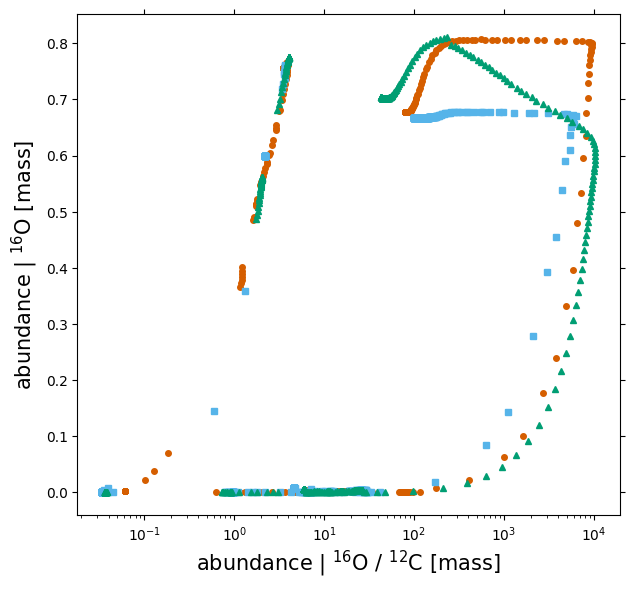

In [9]:
simple.plot(models, '.abundance[o16/c12]', '.abundance[o16]', where='.dataset==Ra02',
            ax_xscale='log');

---
There are specialized plotting functions for CCSNe models which use the suffix *ccsne*, e.g. ``plot_ccsne``. These will plot the data for a given isotope, or isotopes, against the mass coordinate. Many plotting functions also contain shortcuts with a set of predefined arguments. For example the ``abundance`` shortcut automatically passes the ``default_attrname='abundance'`` argument allowing us to only specify the keys to be plotted.

In all plotting functions it is also possible to specify the *unit* of the data to be shown. If necessary simple will automatically convert data between units.

Ra02_m15.abundance: Converting array from ``mass`` to ``mole`` unit by dividing the data by the mass number
Ra02_m20.abundance: Converting array from ``mass`` to ``mole`` unit by dividing the data by the mass number
Ra02_m25.abundance: Converting array from ``mass`` to ``mole`` unit by dividing the data by the mass number


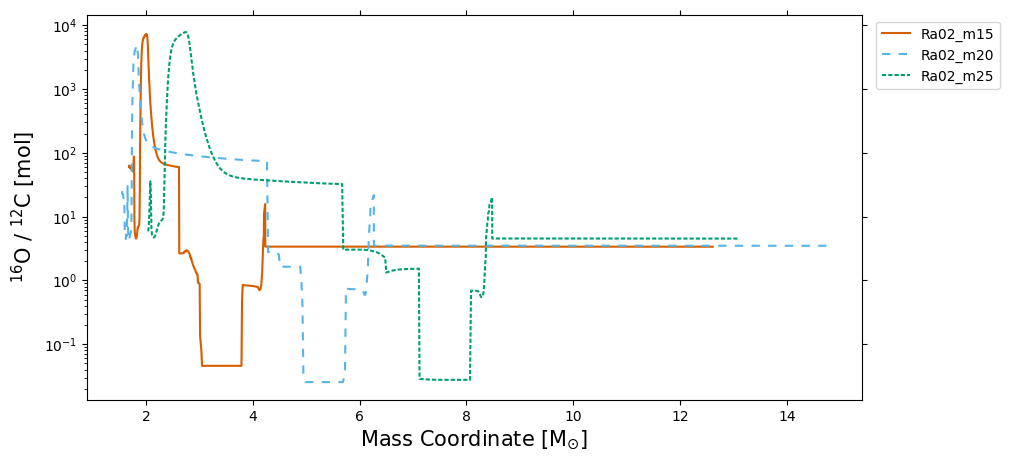

In [10]:
simple.plot_ccsne.abundance(models, 'o16/c12', where='.dataset==Ra02', unit='mol',
                            ax_yscale='log');

---
The specialised CCSNe plotting functions will automatically draw the zonal structure, if available, if a single model is plotted. For more details on how to customise the drawing of the zonal structure see [tutorial 3]().

Below we see the ratio of different Ni isotopes, relative to the most abundance isotope, for the 25 solar mass *Ra02* model. The ``*`` suffix denotes that these the decay of unstable isotopes has been included in these values, as defined in our isolist at the start of this tutorial. 


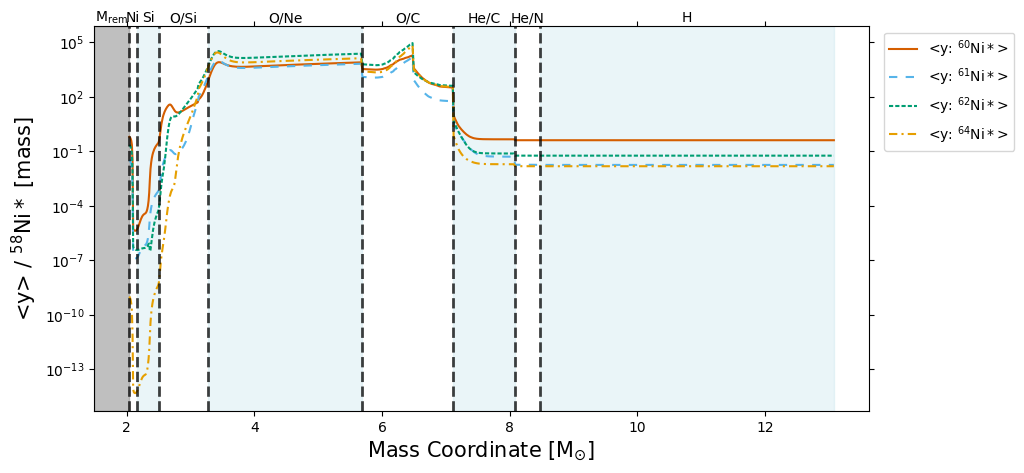

In [13]:
simple.plot_ccsne.abundance(models, 'Ni-60*/Ni-58*, Ni-61*/Ni-58*, Ni-62*/Ni-58*, Ni-64*/Ni-58*', 
                            where='.dataset==Ra02 & .mass==25',
                            ax_yscale='log', fig_size= (10,5));

---
The ``mask`` argument can be used to show only a selection of the data for each model. It can either be a valid index, e.g. and integer or a slice, or a string consisting one or more valid masks. These mask strings can be either a simple index or slice but more complex masks are also possible. For CCSNe for example it is possible to state which zone to plot using ``.zone`` (Similar to how ``where`` strings are evaluated).

In the example below, only data for the *O/Ne* and *O/C* zones are shown.

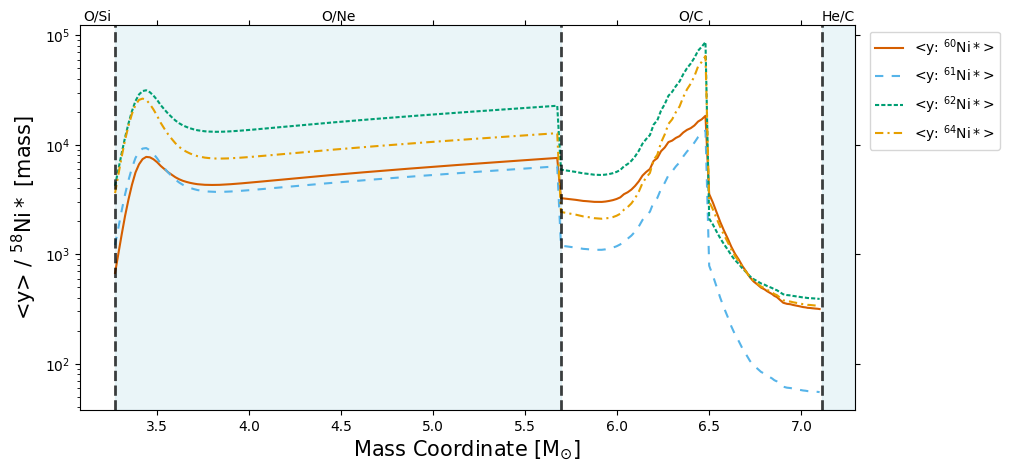

In [12]:
simple.plot_ccsne.abundance(models, 'Ni-60*/Ni-58*, Ni-61*/Ni-58*, Ni-62*/Ni-58*, Ni-64*/Ni-58*', 
                            where='.mass==25 & .dataset==Ra02',
                            mask = '.zone == O/C | .zone == O/Ne',
                            ax_yscale='log');